## Second version for the EWC Notebook

The idea is to try to start from scratch and adapt the code to the data. 

We will for instance try:
- Velocity as a target
- Not normalizing the target
- Start with basic model and add layers if I see it improves
- Do not check outliers here

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
date = '0504'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path = './Data/Processed_Data/Tidy_Sansa_0504Clean.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [9]:
tonic_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [10]:
stim_df = tidy_df.loc[tidy_df.type == 'BC-REACH'].reset_index()

In [11]:
class Model(nn.Module):
    def __init__(self, num_features=124, 
                hidden_units= 3, #was 128
                num_layers = 2, 
                input_size = 50,
                out_dims = 6,):
        super(Model, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_size = input_size
        self.out_dims = out_dims

        self.rnn = nn.RNN(
            input_size = self.num_features, 
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            nonlinearity='tanh', bias= True, 
            batch_first= True, dropout=0.0, 
            bidirectional=False,)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features= self.out_dims)

        def forward(self, x):
            x, _ = self.rnn(x)
            output = self.linear(x)
            
            return output.squeeze()


### Define Hyperparameters for all models

In [12]:
''' Hyper Baseline'''

# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5

l1_ratio_reg = 0.394

lr = 0.000193
loss_function = huber_loss
huber_delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 32
num_layers = 5
input_size_LSTM = 31
dropout_1 = 0.5
dropout_2 = 0.5

#Other training hyperparameters

lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25



## Get train-val-test split

In [13]:
fold = 0

In [16]:
X_train, y_train, X_val, y_val,\
      X_test, y_test, info_train,\
          info_val, info_test, list_mins,\
              list_maxs = train_test_split(data, train_variable = 'both_rates', \
                                           target_variable = 'target_vel', num_folds = 5,
                                           no_outliers = False)

TypeError: 'module' object is not subscriptable

# Here the problem is that the trial length for the features is 75, whereas for the output it is 74. We need to ignore the first/last sample for the features in order to match the output length

In [ ]:

    # Test one of the folds first
    fold_num = 'fold{}'.format(fold)
    fold = fold

    print('We are testing the optimization method on fold ', fold)

    X_train = X_train[fold_num]
    X_val = X_val[fold_num]
    X_test = X_test[fold_num]
    y_test = y_test[fold_num]
    y_train = y_train[fold_num]
    y_val = y_val[fold_num]

    seq_length = 75 if target_variable == 'target_pos'  else 74

    # Reshape x_train to match the number of columns in the model's input layer
    xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
    # Reshape y_train to match the number of neurons in the model's output layer
    yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

    xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
    yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

    xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
    yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

    return xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, info_train, info_val, info_test,  list_mins, list_maxs

In [14]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= 'target_vel', no_outliers = False)

Test trials  6
Val trials 4
We are testing the optimization method on fold  0


ValueError: cannot reshape array of size 172800 into shape (18,74,128)

In [15]:
xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim,\
      xx_test_stim, yy_test_stim, info_train_stim, info_val_stim,\
          info_test_stim,  list_mins_stim, \
            list_maxs_stim = get_dataset(tonic_df, fold, target_variable= 'target_vel', no_outliers = False)

Test trials  7
Val trials 6
We are testing the optimization method on fold  0


ValueError: cannot reshape array of size 211200 into shape (22,74,128)

In [18]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all, \
    xx_test_all, yy_test_all, info_train_all, \
    info_val_all, info_test_all,  list_mins_all,\
          list_maxs_all = get_dataset(tidy_df,fold, target_variable= 'target_vel', no_outliers = False)

Test trials  26
Val trials 21
We are testing the optimization method on fold  0


In [20]:
yy_train_base.shape

(18, 75, 3)

In [18]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [19]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

## Baseline Model

In [20]:
''' Hyper Baseline'''

# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5

l1_ratio_reg = 0.5

lr = 0.0001# 0.0002
loss_function = huber_loss
huber_delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 32
num_layers = 2
input_size_LSTM = 31
dropout_1 = 0.2
dropout_2 = 0.2

#Other training hyperparameters

lr_gamma= 0.9 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25

In [21]:
# Fit the LSTM model
model_base = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

model_base.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [22]:
train_losses, val_losses = \
    train_model(model_base, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 7)


Epoch 000 Train 0.0449 Val 0.0399
Epoch 001 Train 0.0416 Val 0.0351
Epoch 002 Train 0.0367 Val 0.0269
Epoch 003 Train 0.0293 Val 0.0173
Epoch 004 Train 0.0226 Val 0.0123
Epoch 005 Train 0.0197 Val 0.0106
Epoch 006 Train 0.0183 Val 0.0096
Epoch 007 Train 0.0172 Val 0.0088
Epoch 008 Train 0.0161 Val 0.0082
Epoch 009 Train 0.0153 Val 0.0075
Epoch 010 Train 0.0143 Val 0.0072
Epoch 011 Train 0.0135 Val 0.0069
Epoch 012 Train 0.0127 Val 0.0065
Epoch 013 Train 0.0121 Val 0.0062
Epoch 014 Train 0.0115 Val 0.0059
Epoch 015 Train 0.0110 Val 0.0057
Epoch 016 Train 0.0106 Val 0.0055
Epoch 017 Train 0.0100 Val 0.0052
Epoch 018 Train 0.0096 Val 0.0051
Epoch 019 Train 0.0091 Val 0.0049
Epoch 020 Train 0.0087 Val 0.0048
Epoch 021 Train 0.0083 Val 0.0045
Epoch 022 Train 0.0079 Val 0.0044
Epoch 023 Train 0.0075 Val 0.0043
Epoch 024 Train 0.0071 Val 0.0042
Epoch 025 Train 0.0068 Val 0.0041
Epoch 026 Train 0.0064 Val 0.0039
Epoch 027 Train 0.0062 Val 0.0038
Epoch 028 Train 0.0060 Val 0.0037
Epoch 029 Trai

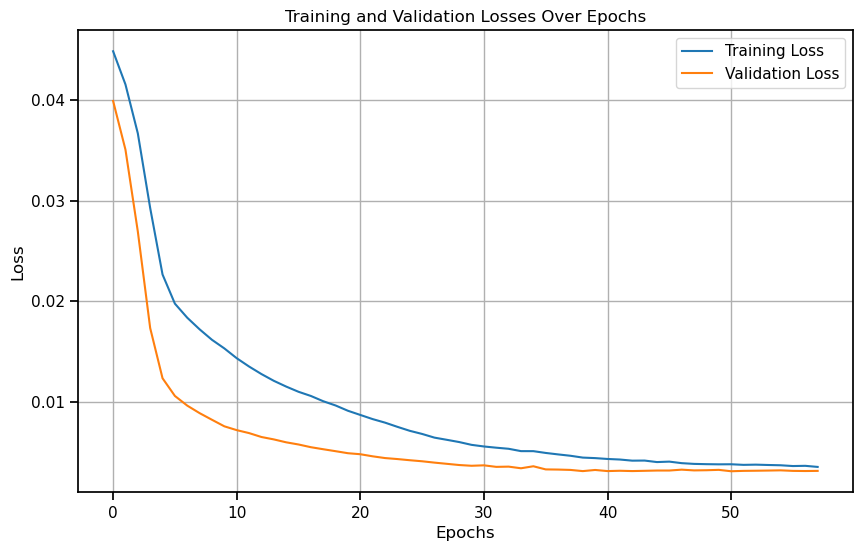

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_base, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [ ]:
model_baselineonly = torch.load(path_to_save_model_fold)
model_baselineonly.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
def reshape_to_eval(x,y, model):
    # Convert X_train and y_train to PyTorch tensors
    inputs = torch.tensor(x, device=device, dtype=torch.float32)
    targets = torch.tensor(y, device=device, dtype=torch.float32)

    y_pred = model(inputs)
    y_array = targets.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D



def eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'rmse'):

    #Move tensors to cpu and reshape them for evaluation
    y_true_train, y_pred_train = reshape_to_eval(xx_train,yy_train, model)
    y_true_val, y_pred_val = reshape_to_eval(xx_val,yy_val, model)
    y_true_test, y_pred_test = reshape_to_eval(xx_test,yy_test, model)

    if metric == 'rmse':
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
        print('Train Score: %.2f RMSE' % (trainScore))
        valScore = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
        print('Val Score: %.2f RMSE' % (valScore))
        testScore = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
        print('Test Score: %.2f RMSE' % (testScore))

        return y_pred_val, y_true_val,trainScore, valScore, testScore
    
    elif metric == 'ev':
        #Compute explained variance
        ev_train = explained_variance_score(y_true_train, y_pred_train)
        ev_val = explained_variance_score(y_true_val, y_pred_val)
        ev_test = explained_variance_score(y_true_test, y_pred_test)
        print('Train EV: %.2f ' % (ev_train))
        print('Val EV: %.2f ' % (ev_val))
        print('Test EV: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test
    
    elif metric == 'r2':
        #Compute explained variance
        ev_train = r2_score(y_true_train, y_pred_train)
        ev_val = r2_score(y_true_val, y_pred_val)
        ev_test = r2_score(y_true_test, y_pred_test)
        print('Train R2: %.2f ' % (ev_train))
        print('Val R2: %.2f ' % (ev_val))
        print('Test R2: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_baselineonly, metric = 'ev')

Train EV: 0.82 
Val EV: 0.68 
Test EV: 0.00 


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_baselineonly, metric = 'r2')

Train R2: 0.82 
Val R2: 0.67 
Test R2: -37.21 


In [ ]:
y_true_train, y_pred_train = reshape_to_eval(xx_train_base,yy_train_base, model_baselineonly)

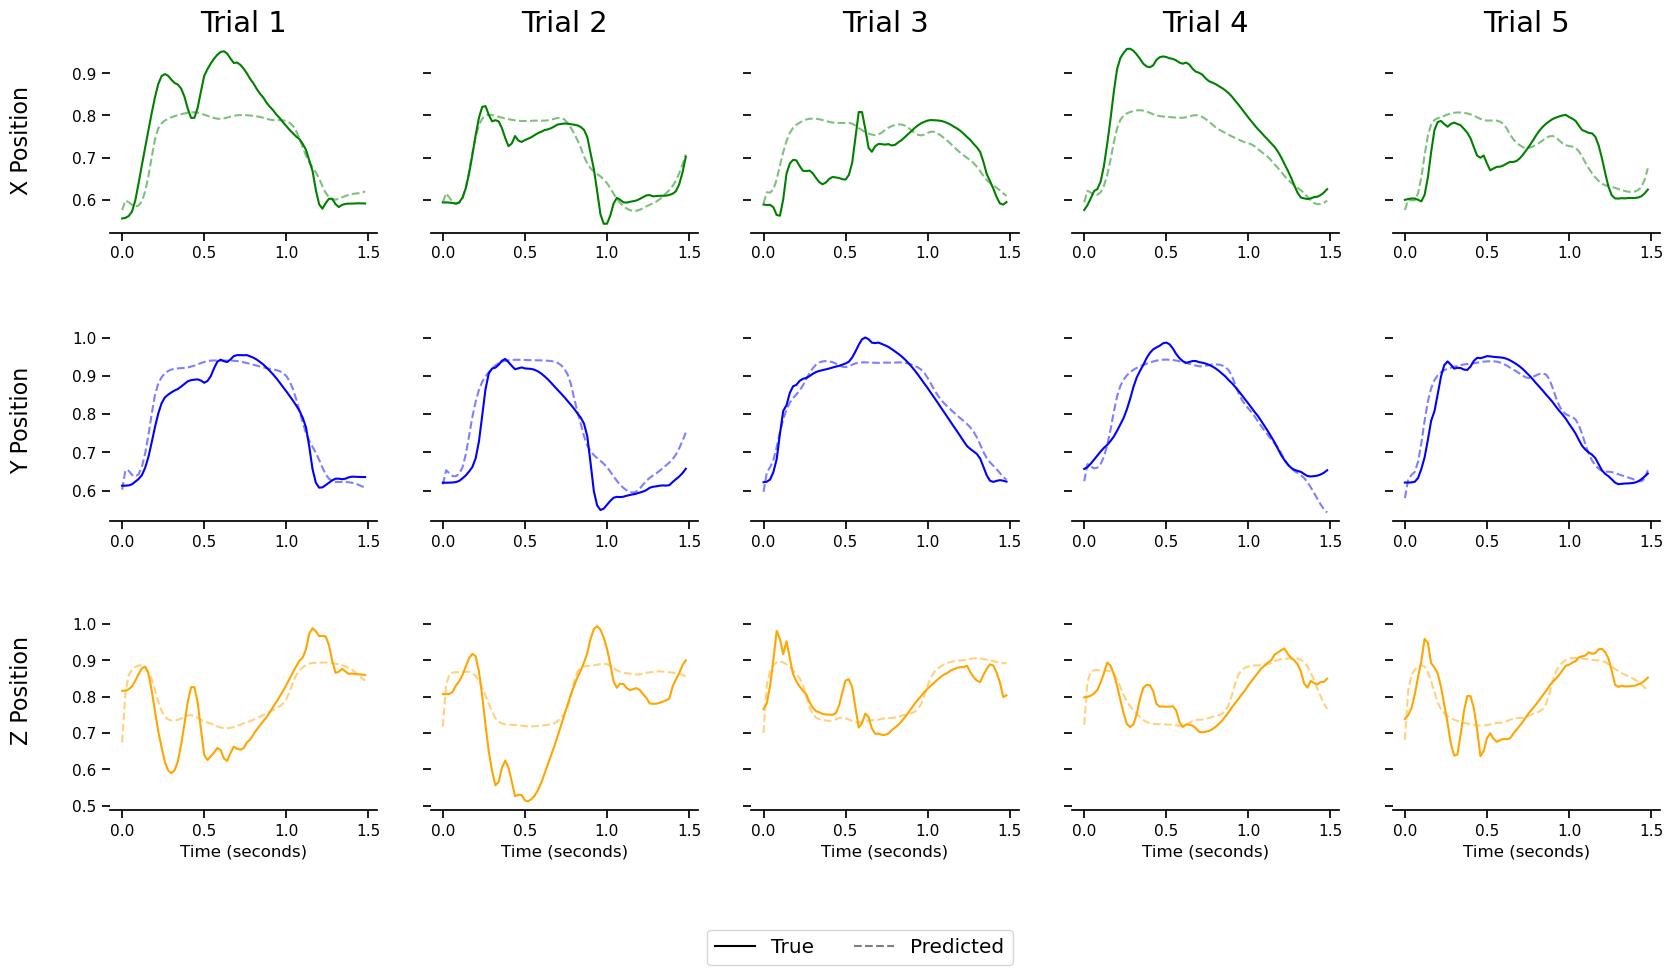

In [ ]:
visualize_LSTM_test(y_pred_train, y_true_train, seq_length = 75)

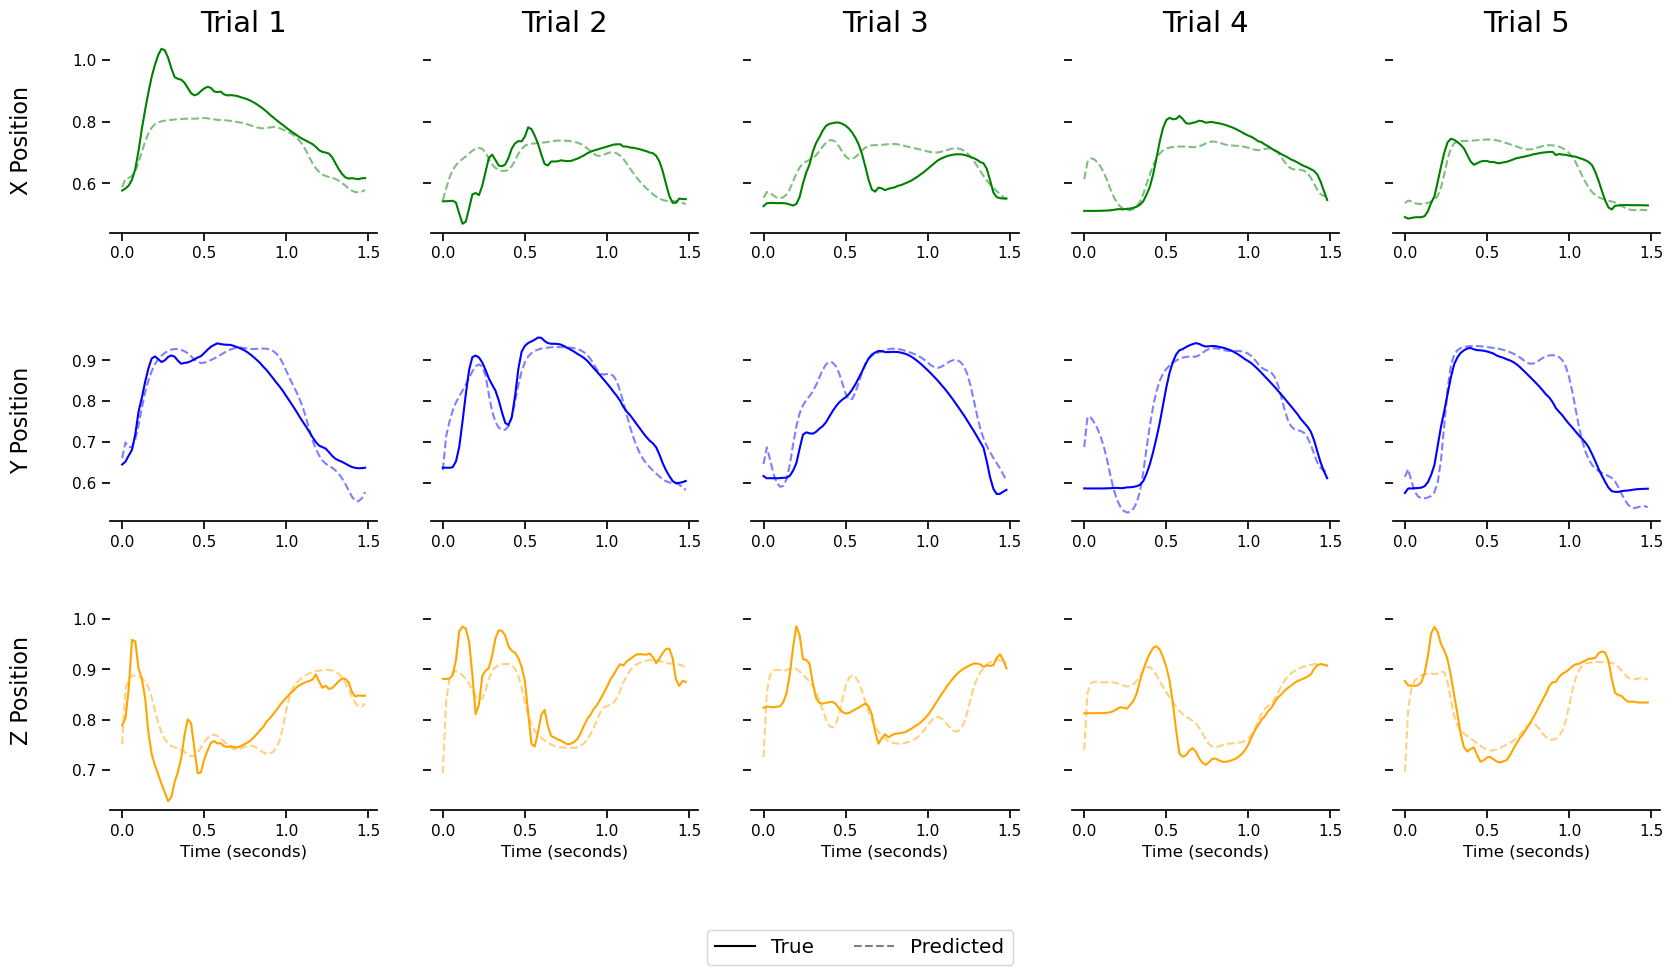

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Testing the model on stimulation data

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_baselineonly, metric = 'ev')

Train EV: 0.45 
Val EV: 0.43 
Test EV: 0.00 


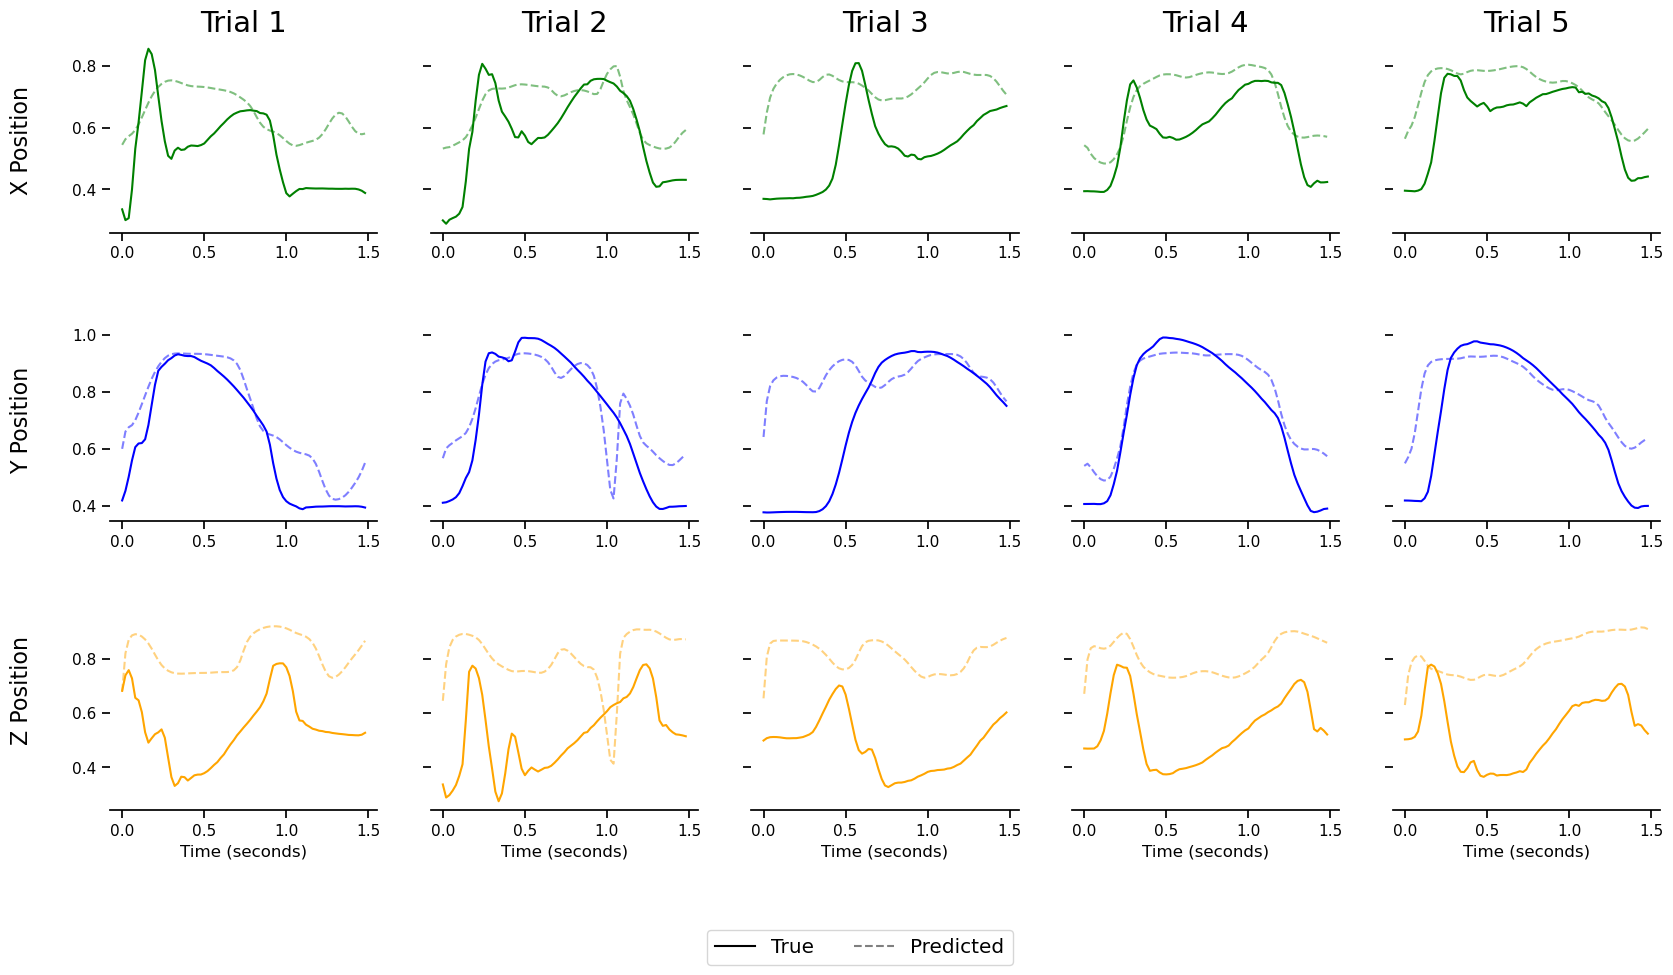

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Now we use all data for training

In [ ]:
# Fit the LSTM model
model_all = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_all.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
train_losses, val_losses = \
    train_model(model_all, xx_train_all,yy_train_all,
                xx_val_all, 
                yy_val_all,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0142 Val 0.0086
Epoch 001 Train 0.0079 Val 0.0062
Epoch 002 Train 0.0066 Val 0.0054
Epoch 003 Train 0.0059 Val 0.0052
Epoch 004 Train 0.0055 Val 0.0049
Epoch 005 Train 0.0052 Val 0.0047
Epoch 006 Train 0.0049 Val 0.0046
Epoch 007 Train 0.0047 Val 0.0045
Epoch 008 Train 0.0045 Val 0.0045
Epoch 009 Train 0.0042 Val 0.0045
Epoch 010 Train 0.0040 Val 0.0045
Epoch 011 Train 0.0038 Val 0.0046
Epoch 012 Train 0.0036 Val 0.0048
Epoch 013 Train 0.0034 Val 0.0047
Epoch 014 Train 0.0032 Val 0.0047
Decrease LR
Epoch 015 Train 0.0031 Val 0.0048
Epoch 016 Train 0.0030 Val 0.0048
Epoch 017 Train 0.0029 Val 0.0048
Epoch 018 Train 0.0029 Val 0.0049
Epoch 019 Train 0.0028 Val 0.0050
Decrease LR
8


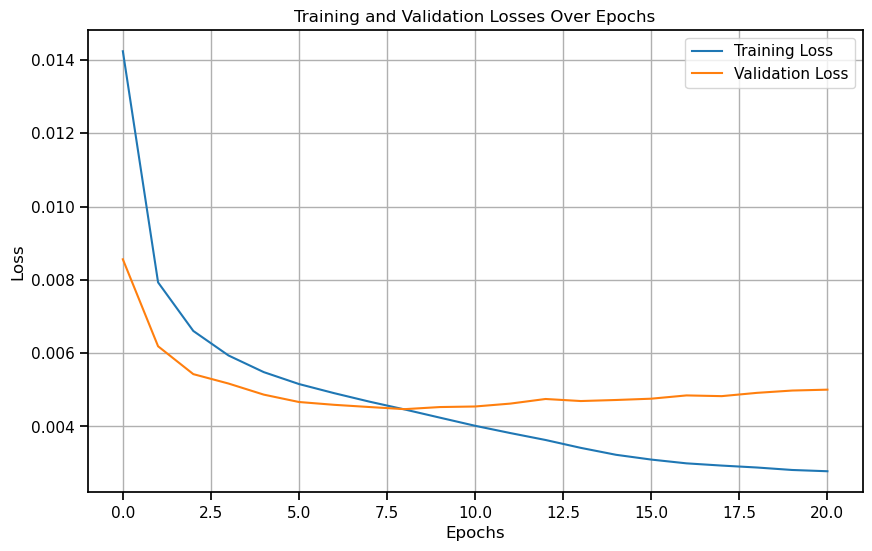

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Alldata'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_all, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [ ]:
model_all_data = torch.load(path_to_save_model_fold)
model_all_data.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, model_all_data, metric = 'ev')

Train EV: 0.74 
Val EV: 0.67 
Test EV: 0.01 


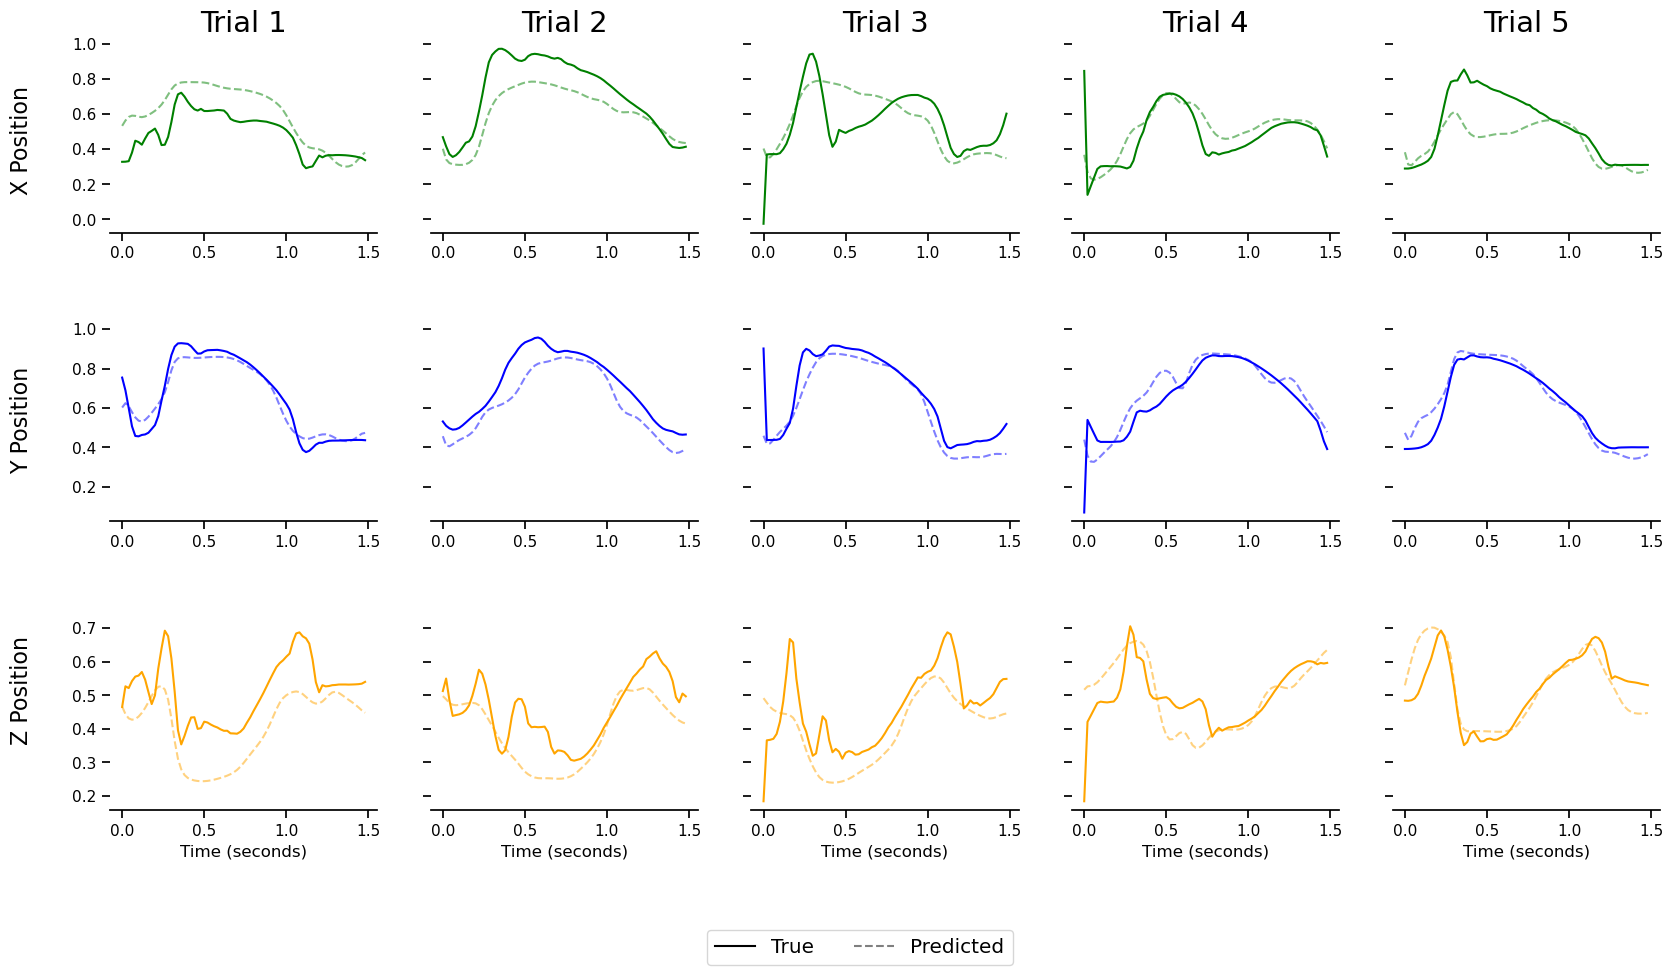

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Implementing EWC

In [ ]:
def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        _loss = fisher[n] * (p - p_old[n]) ** 2
        loss += _loss.sum()
    return loss

In [ ]:
x = to_t_eval(xx_train_base) 
y = to_t_eval(yy_train_base)

In [ ]:
# Assuming X_train and y_train are NumPy arrays or PyTorch tensors
dataset = list(zip(x, y))

In [ ]:
experiment_name_base = 'LSTM_2018'+date+'_Baseline'
path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))


In [ ]:
model_baselineonly = torch.load(path_model_baseline)
model_baselineonly.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
params = {n: p for n, p in model_baselineonly.named_parameters() if p.requires_grad}
p_old = {}

for n, p in deepcopy(params).items():
    p_old[n] = p.data

In [ ]:
def get_fisher_diag(model, dataset, params, empirical=True):
 
    fisher = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher[n] = p.data

    
    for input, gt_label in dataset:
        model.zero_grad()
        output = model(input).view(-1)
        if empirical:
            label = gt_label.view(-1)
            
        else:
            label = output.max(1)[1].view(-1)
            

        h_loss  = huber_loss(output, label)
        #negloglikelihood = F.nll_loss(F.log_softmax(output, dim = -1), label)
        #negloglikelihood.backward()
        model.train()
        h_loss.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [ ]:
fisher_matrix = get_fisher_diag(model_baselineonly, dataset, params)

In [ ]:
def train_model_EWC(model, X,Y,
                X_val, 
                Y_val,
                lr=lr, # 0.0001,
                lr_step_size= lr_step_size ,#10,
                lr_gamma=lr_gamma,#0.9,
                sequence_length_LSTM= seq_length_LSTM, #10,
                batch_size_train = batch_size_train, #3,
                batch_size_val = batch_size_val,# 3,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None,
                l1_ratio = l1_ratio_reg, #0.5,
                alpha = alpha_reg, #1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=sequence_length_LSTM)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=sequence_length_LSTM)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                X_ = X_.to(device)
                y_ = y_.to(device)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = huber_loss(output_t, y_, delta = delta)
                        
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            ewc_loss = get_ewc_loss(model, fisher_matrix, p_old)
                            loss_t += lambda_ewc * ewc_loss
                        #     loss += regularizer(model, l1_ratio, alpha)
                        # Compute gradients and perform an optimization step
                        loss_t.backward(retain_graph=True)
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = huber_loss(output_t, y_, delta = delta)
                    

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [ ]:
train_losses, val_losses = \
    train_model_EWC(model_baselineonly, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= True,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2
                )


Epoch 000 Train 0.0183 Val 0.0126
Epoch 001 Train 0.0129 Val 0.0104
Epoch 002 Train 0.0105 Val 0.0093
Epoch 003 Train 0.0093 Val 0.0086
Epoch 004 Train 0.0086 Val 0.0082
Epoch 005 Train 0.0080 Val 0.0079
Epoch 006 Train 0.0075 Val 0.0077
Epoch 007 Train 0.0072 Val 0.0076
Epoch 008 Train 0.0068 Val 0.0074
Epoch 009 Train 0.0066 Val 0.0073
Epoch 010 Train 0.0063 Val 0.0072
Epoch 011 Train 0.0061 Val 0.0071
Epoch 012 Train 0.0059 Val 0.0070
Epoch 013 Train 0.0058 Val 0.0070
Epoch 014 Train 0.0056 Val 0.0070
Epoch 015 Train 0.0055 Val 0.0069
Epoch 016 Train 0.0053 Val 0.0068
Epoch 017 Train 0.0052 Val 0.0067
Epoch 018 Train 0.0051 Val 0.0067
Epoch 019 Train 0.0049 Val 0.0067
Epoch 020 Train 0.0048 Val 0.0066
Epoch 021 Train 0.0046 Val 0.0065
Epoch 022 Train 0.0045 Val 0.0066
Epoch 023 Train 0.0044 Val 0.0064
Epoch 024 Train 0.0043 Val 0.0064
Epoch 025 Train 0.0042 Val 0.0064
Epoch 026 Train 0.0041 Val 0.0064
Epoch 027 Train 0.0040 Val 0.0063
Epoch 028 Train 0.0039 Val 0.0062
Epoch 029 Trai

In [ ]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_EWC'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [ ]:
model_EWC = torch.load(path_to_save_model_fold)
model_EWC.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

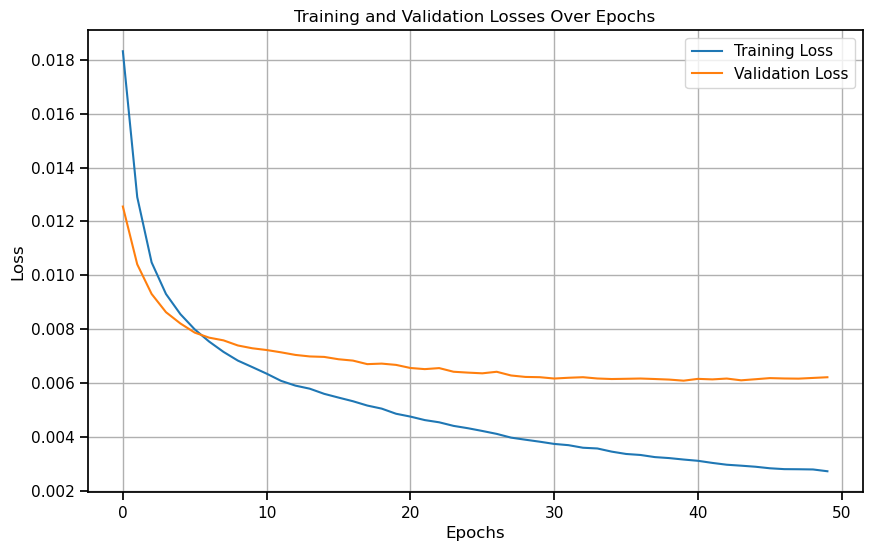

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_EWC, metric = 'ev')

Train EV: 0.88 
Val EV: 0.72 
Test EV: 0.01 


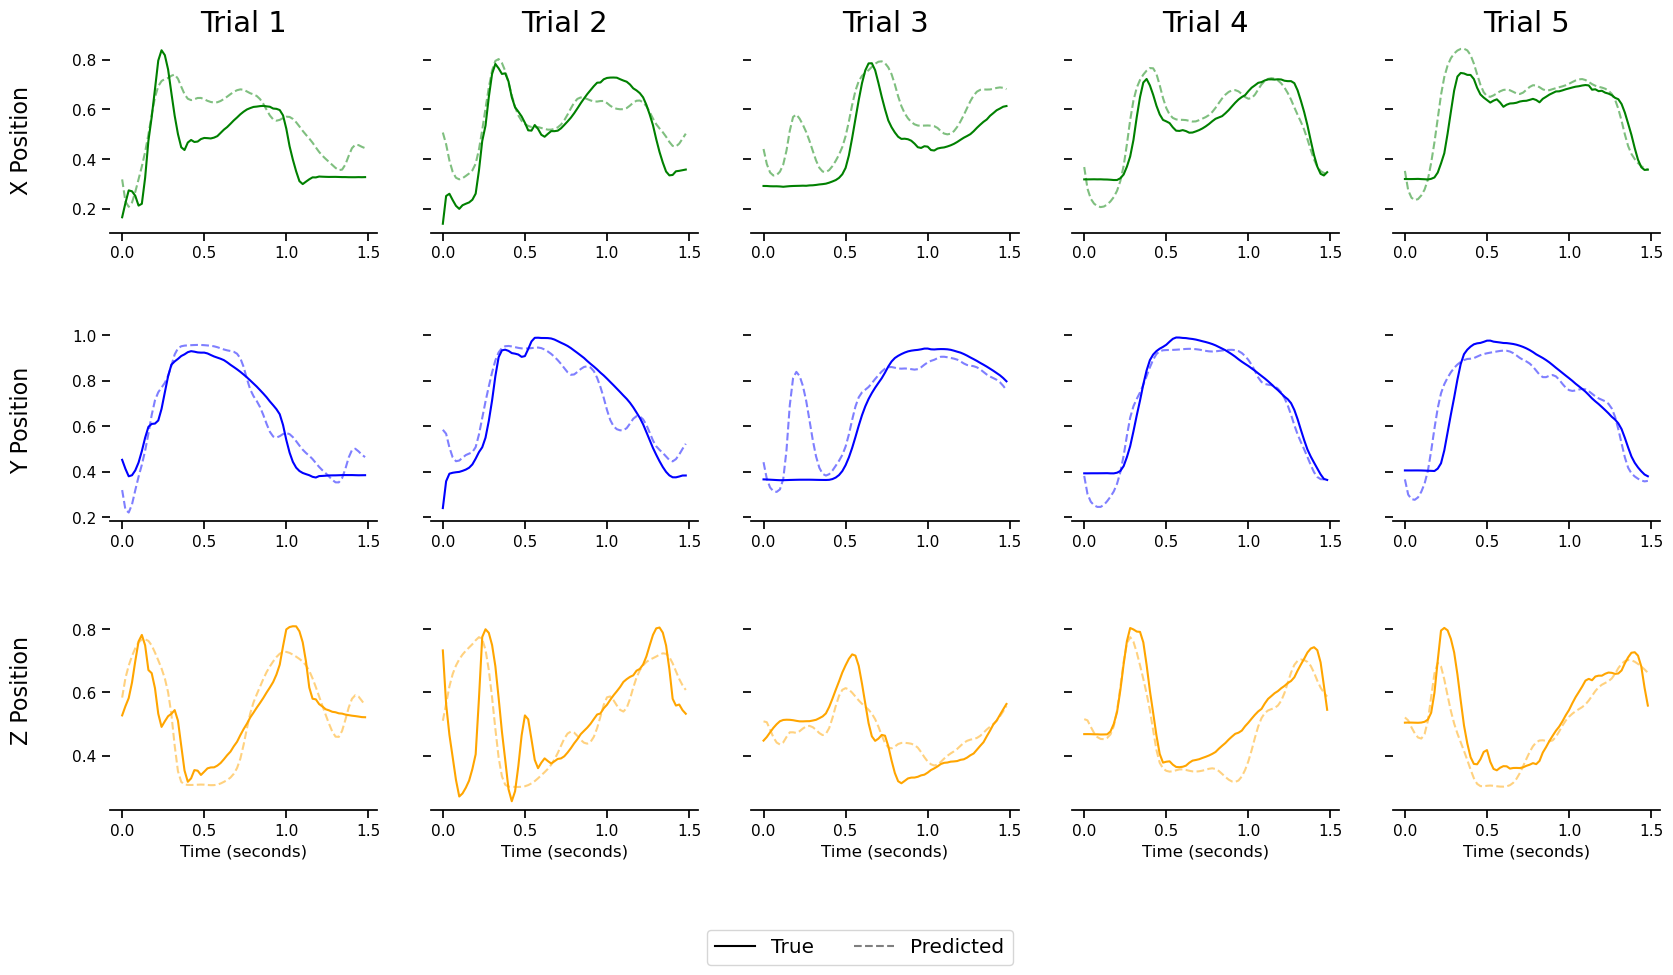

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Testing the performance of the model on Baseline data after EWC

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_EWC, metric = 'ev')

Train EV: 0.26 
Val EV: 0.29 
Test EV: 0.01 


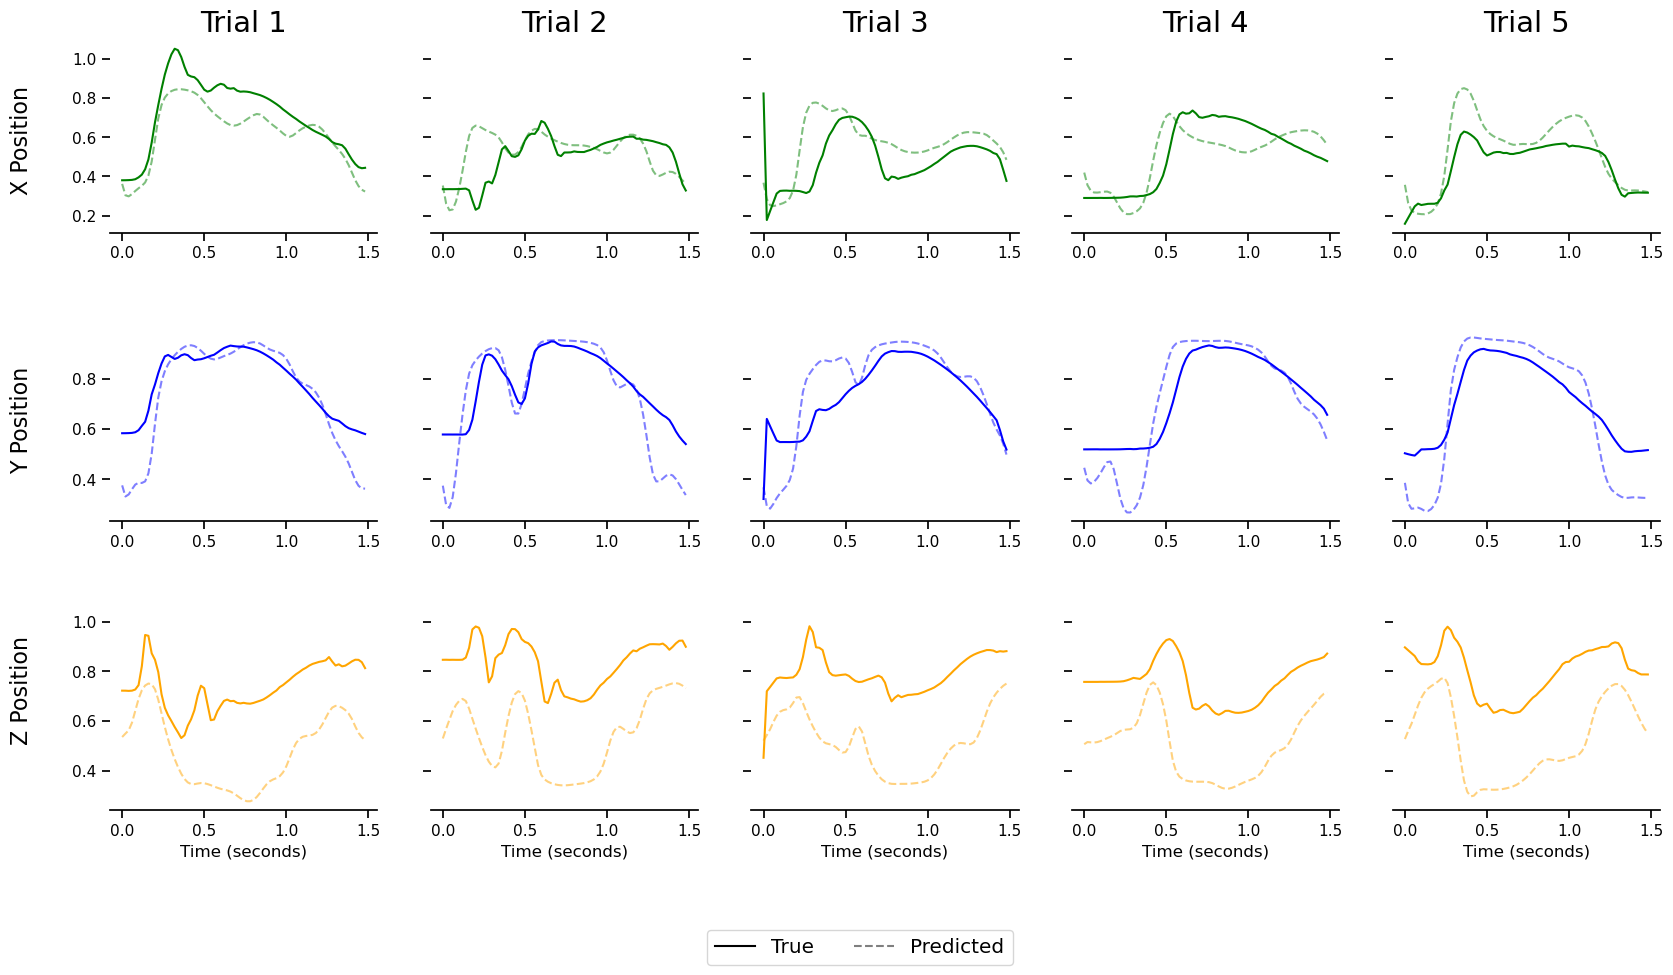

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Training model only on stimulation data and testing on baseline data

In [ ]:
# Fit the LSTM model
model_stim = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_stim.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
train_losses, val_losses = \
    train_model(model_stim, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0254 Val 0.0207
Epoch 001 Train 0.0234 Val 0.0183
Epoch 002 Train 0.0192 Val 0.0141
Epoch 003 Train 0.0142 Val 0.0112
Epoch 004 Train 0.0116 Val 0.0096
Epoch 005 Train 0.0101 Val 0.0088
Epoch 006 Train 0.0092 Val 0.0083
Epoch 007 Train 0.0084 Val 0.0080
Epoch 008 Train 0.0078 Val 0.0077
Epoch 009 Train 0.0072 Val 0.0074
Epoch 010 Train 0.0068 Val 0.0073
Epoch 011 Train 0.0065 Val 0.0072
Epoch 012 Train 0.0062 Val 0.0070
Epoch 013 Train 0.0059 Val 0.0069
Epoch 014 Train 0.0057 Val 0.0068
Epoch 015 Train 0.0055 Val 0.0068
Epoch 016 Train 0.0052 Val 0.0066
Epoch 017 Train 0.0050 Val 0.0065
Epoch 018 Train 0.0049 Val 0.0065
Epoch 019 Train 0.0047 Val 0.0064
Epoch 020 Train 0.0045 Val 0.0063
Epoch 021 Train 0.0044 Val 0.0063
Epoch 022 Train 0.0043 Val 0.0063
Epoch 023 Train 0.0041 Val 0.0062
Epoch 024 Train 0.0040 Val 0.0062
Epoch 025 Train 0.0039 Val 0.0062
Epoch 026 Train 0.0038 Val 0.0062
Epoch 027 Train 0.0037 Val 0.0062
Epoch 028 Train 0.0036 Val 0.0062
Epoch 029 Trai

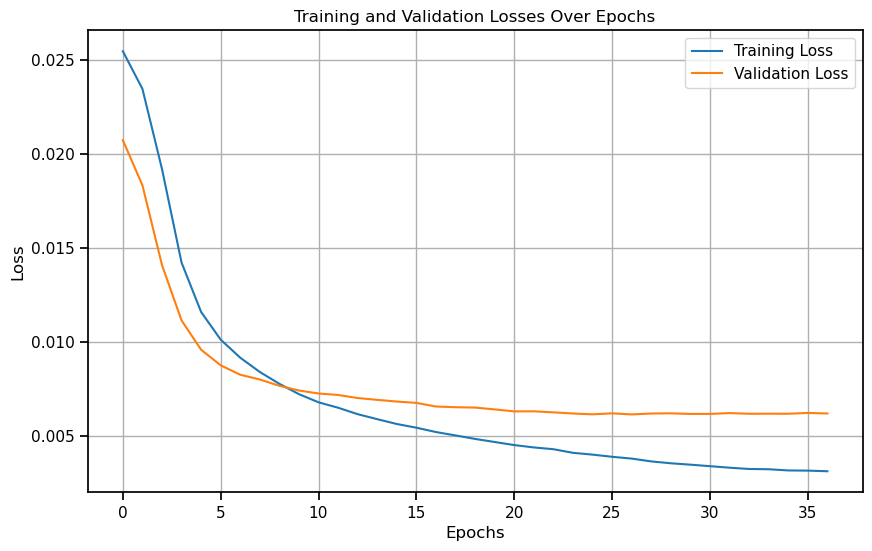

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stim, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)


In [ ]:
model_stim = torch.load(path_to_save_model_fold)
model_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim, metric = 'ev')

Train EV: 0.87 
Val EV: 0.67 
Test EV: 0.01 


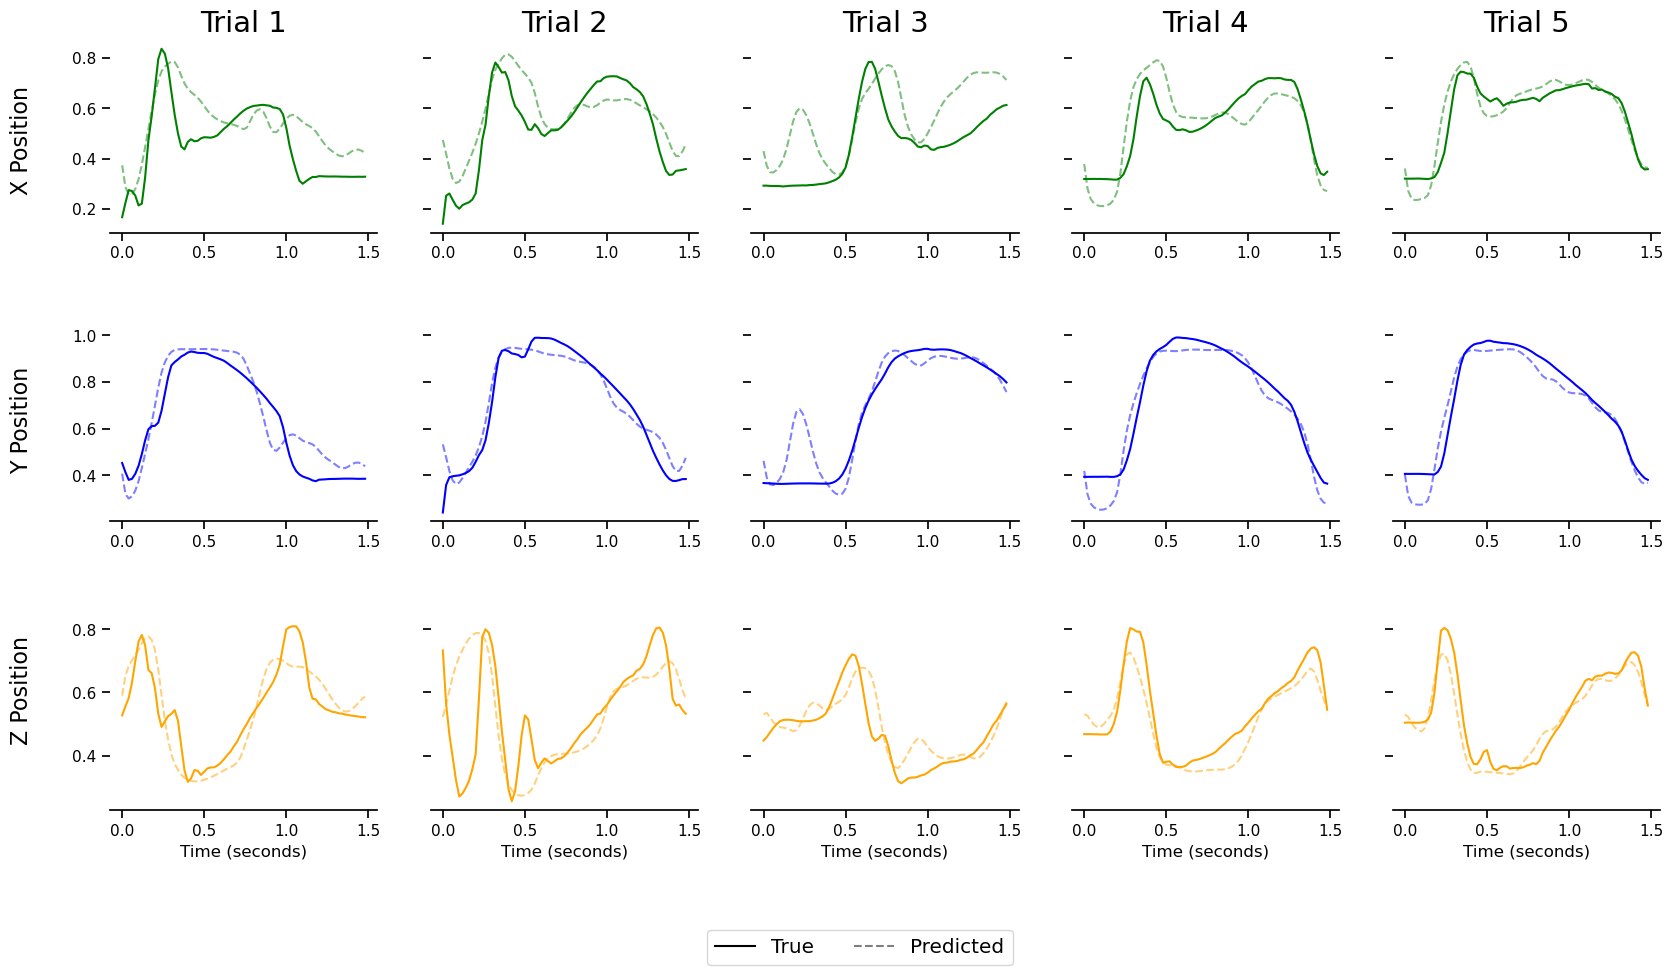

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Now test on baseline data to compare to the EWC

In [ ]:
model_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim, metric = 'ev')

Train EV: 0.10 
Val EV: 0.24 
Test EV: 0.01 


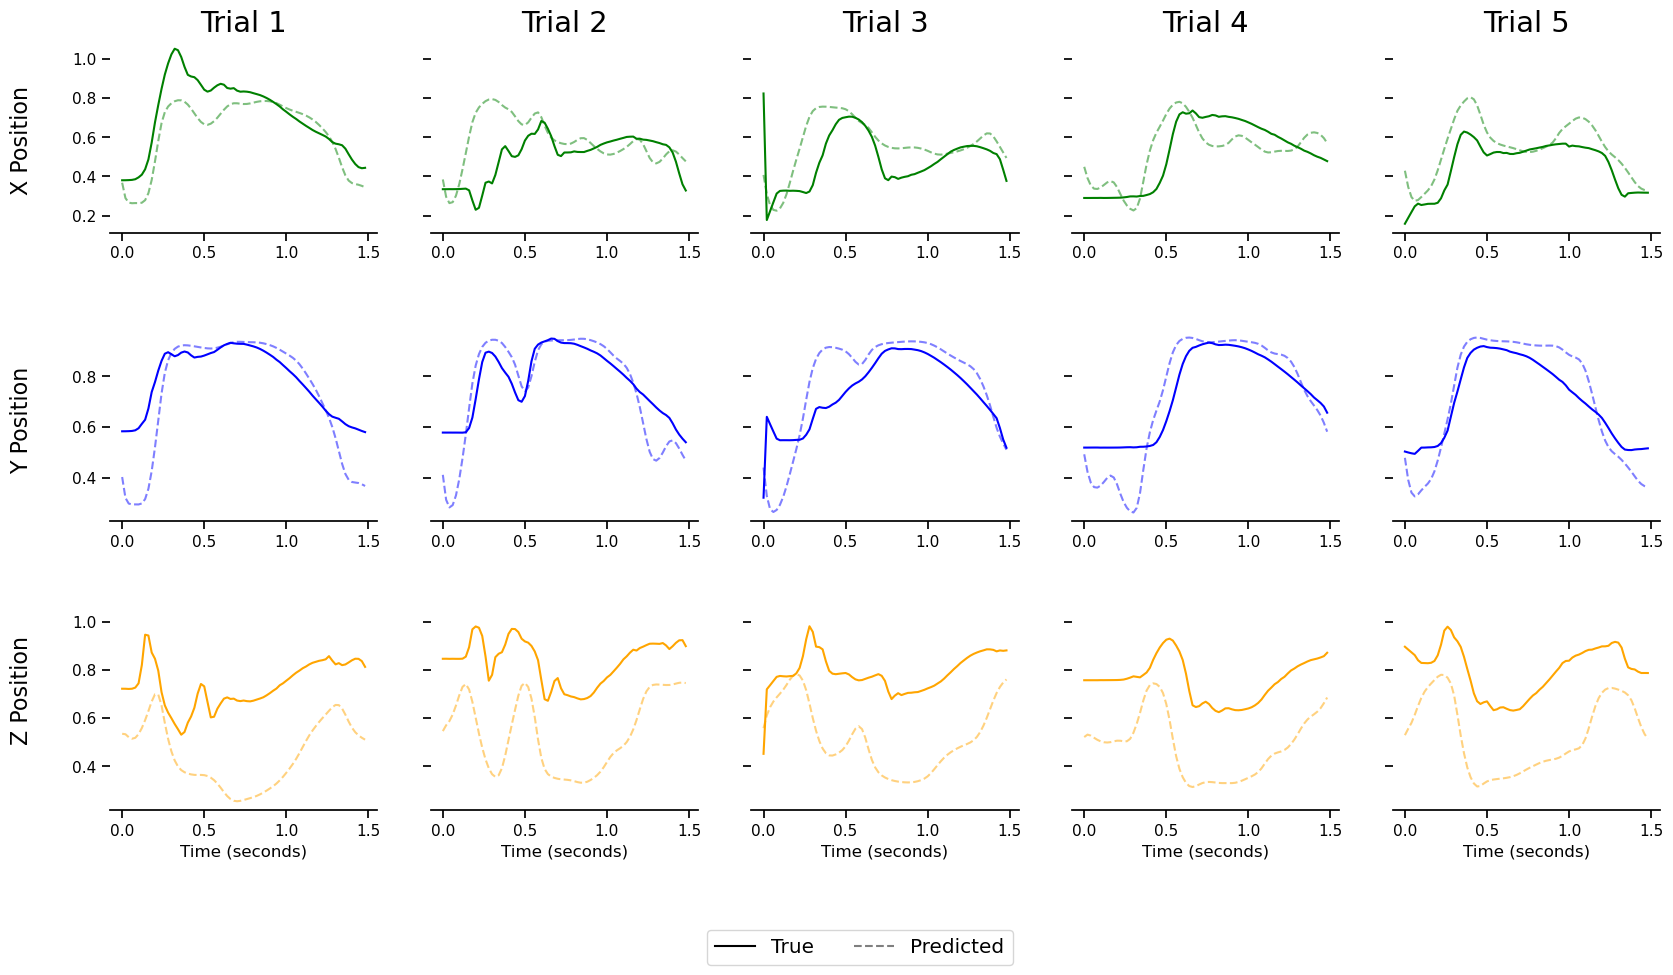

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Checking Catastrophic Forgetting

The idea here is to take models trained for one specific task, train them on the other task and then see how they generalize or not.

In [ ]:
path_to_models = './Models'


In [ ]:
experiment_name_base = 'LSTM_2018'+date+'_Baseline'
experiment_name_stim= 'LSTM_2018'+date+'_Stimulation'

In [ ]:
path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))
path_model_stim = os.path.join(path_to_models, experiment_name_stim, 'fold_{}.pth'.format(fold))

In [ ]:
model_baselineonly = torch.load(path_model_baseline)
model_baselineonly.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
model_stimonly = torch.load(path_model_stim)
model_stimonly.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

#### Training on stimulation data using baseline model

In [ ]:
train_losses, val_losses = \
    train_model(model_baselineonly, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0183 Val 0.0127
Epoch 001 Train 0.0130 Val 0.0103
Epoch 002 Train 0.0106 Val 0.0092
Epoch 003 Train 0.0093 Val 0.0086
Epoch 004 Train 0.0085 Val 0.0082
Epoch 005 Train 0.0079 Val 0.0079
Epoch 006 Train 0.0075 Val 0.0077
Epoch 007 Train 0.0072 Val 0.0075
Epoch 008 Train 0.0068 Val 0.0074
Epoch 009 Train 0.0066 Val 0.0073
Epoch 010 Train 0.0063 Val 0.0072
Epoch 011 Train 0.0061 Val 0.0071
Epoch 012 Train 0.0059 Val 0.0071
Epoch 013 Train 0.0058 Val 0.0070
Epoch 014 Train 0.0055 Val 0.0069
Epoch 015 Train 0.0054 Val 0.0069
Epoch 016 Train 0.0052 Val 0.0068
Epoch 017 Train 0.0051 Val 0.0069
Epoch 018 Train 0.0050 Val 0.0067
Epoch 019 Train 0.0049 Val 0.0066
Epoch 020 Train 0.0047 Val 0.0065
Epoch 021 Train 0.0046 Val 0.0066
Epoch 022 Train 0.0045 Val 0.0065
Epoch 023 Train 0.0044 Val 0.0064
Epoch 024 Train 0.0042 Val 0.0065
Epoch 025 Train 0.0042 Val 0.0064
Epoch 026 Train 0.0041 Val 0.0063
Epoch 027 Train 0.0040 Val 0.0063
Epoch 028 Train 0.0039 Val 0.0063
Epoch 029 Trai

In [ ]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation_after_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold)

In [ ]:
model_stim_after_base = torch.load(path_to_save_model_fold)
model_stim_after_base.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim_after_base, metric = 'ev')

Train EV: 0.26 
Val EV: 0.30 
Test EV: 0.01 


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim_after_base, metric = 'ev')

Train EV: 0.89 
Val EV: 0.72 
Test EV: 0.01 


#### Training on baseline data using stimulation model

In [ ]:
train_losses, val_losses = \
    train_model(model_stimonly, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0240 Val 0.0128
Epoch 001 Train 0.0192 Val 0.0095
Epoch 002 Train 0.0171 Val 0.0078
Epoch 003 Train 0.0161 Val 0.0069
Epoch 004 Train 0.0155 Val 0.0063
Epoch 005 Train 0.0151 Val 0.0060
Epoch 006 Train 0.0147 Val 0.0057
Epoch 007 Train 0.0144 Val 0.0055
Epoch 008 Train 0.0140 Val 0.0054
Epoch 009 Train 0.0136 Val 0.0053
Epoch 010 Train 0.0132 Val 0.0052
Epoch 011 Train 0.0130 Val 0.0051
Epoch 012 Train 0.0126 Val 0.0050
Epoch 013 Train 0.0123 Val 0.0051
Epoch 014 Train 0.0120 Val 0.0050
Epoch 015 Train 0.0117 Val 0.0051
Epoch 016 Train 0.0113 Val 0.0051
Decrease LR
Epoch 017 Train 0.0110 Val 0.0051
Epoch 018 Train 0.0108 Val 0.0051
Epoch 019 Train 0.0106 Val 0.0052
Epoch 020 Train 0.0104 Val 0.0052
Epoch 021 Train 0.0102 Val 0.0052
Decrease LR
12


In [ ]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline_after_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stimonly, path_to_save_model_fold)

In [ ]:
model_base_after_stim = torch.load(path_to_save_model_fold)
model_base_after_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base_after_stim, metric = 'ev')

Train EV: 0.70 
Val EV: 0.58 
Test EV: 0.01 


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base_after_stim, metric = 'ev')

Train EV: 0.51 
Val EV: 0.71 
Test EV: 0.00 
